# <span style="color:blue"> Esercitazione 12 - Riconoscimento di Immagini Tramite Reti Neurali </span>

## <span style="color:blue"> Indice</span>

- [Esercizio 12.1 - Addestramento di un DNN con aumento delle epoche](#Esercizio12.1)

- [Esercizio 12.2 - Addestramento di una rete neurale convoluzionale (CNN)](#Esercizio12.2)

- [Esercizio 12.3 - Riconoscimento di 10 cifre scritte a mano](#Esercizio12.3)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import os
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam

## <span id="Esercizio12.1" style="color:blue">Esercizio 12.1 - Addestramento di un DNN con aumento delle epoche [^](#toc)

### Descrizione

L’obiettivo dell’esercizio è utilizzare modelli di reti neurali profonde, implementati nel pacchetto Python Keras, per riconoscere e distinguere dieci cifre scritte a mano (0–9)

Il dataset `MNIST` è composto da $70000$ cifre da $0$ a $9$ scritte a mano, ciascuna rappresentata da un’immagine quadrata suddivisa in una griglia di $28×28$ pixel. Ogni pixel può assumere $256$ livelli di grigio, interpolando tra il bianco e il nero, e quindi ciascun dato può assumere un valore nell’insieme {$0,1,…,255$}. Il problema affrontato è un tipico compito di classificazione.

### Calcolo e risultati

Gli step necessari per lo svolgimento dell'esercizio sono i seguenti:

1. Caricare e processare i dati
2. Definire la rete neurale utilizzata e la sua architettura
3. Scegliere le metriche, l'optimizer e la funzione costo
4. Addestrare il modello
5. Valutare la performance del modello su nuovi dati

In questo esercizio verrà utilizzata una rete neurale profonda (_DNN_) in cui ogni neurone appartenente ad un layer è connesso ad i neuroni del layer precedente. Per questo motivo le immagini $28$x$28$ del dataset `MNIST` vengono convertite in un vettore di $784$ valori.  

In [2]:
# Input image dimensions
img_righe,img_colonne=28,28  # Number of pixels 
# Output
num_classi=10                # 10 digits

In [3]:
# 1. Load and process data
# Load data
(x_t, y_t),(x_test, y_test)=mnist.load_data() # Train and test data

# Reshape data
x_t=x_t.reshape(x_t.shape[0],img_righe*img_colonne)
x_test=x_test.reshape(x_test.shape[0],img_righe*img_colonne)
x_t=x_t.astype('float32')/255
x_test=x_test.astype('float32')/255
y_t=keras.utils.to_categorical(y_t,num_classi)
y_test=keras.utils.to_categorical(y_test,num_classi)

# 2. Define DNN architecture
def build_dnn():
    network=Sequential()
    network.add(Input(shape=(img_righe*img_colonne,)))
    network.add(Dense(400,activation='relu'))
    network.add(Dense(100,activation='relu'))
    network.add(Dropout(0.5))                             # Regularization
    network.add(Dense(num_classi, activation='softmax'))  # Output layer
    
    return network

# 3. Compile DNN model with different optimizers
def compile_dnn(optimizer):
    network=build_dnn()
    network.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['acc'])
    return network

# 4. Train DNN model
def train_dnn(optimizer,N_epochs):
    network=compile_dnn(optimizer)
    history=network.fit(x_t,y_t,batch_size=32,epochs=N_epochs,shuffle=True,verbose=0,validation_data=(x_test, y_test))
    loss,accuracy=network.evaluate(x_test,y_test,batch_size=32,verbose=0)
    return network,history,loss,accuracy

La scelta dell’ottimizzatore e del numero di epoche influisce in modo significativo sulla qualità dell’addestramento. Per valutare il comportamento del modello sono stati confrontati diversi ottimizzatori al variare delle epoche, al fine di individuare un compromesso tra accuracy e loss. 

Nell’analisi è stato inizialmente fissato $N_{\mathrm{epochs}}=20$ per confrontare le prestazioni dei diversi ottimizzatori (`sgd`, `adam` e `rmsprop`). In questo caso non viene riportata l'analisi dettagliata fra i tre modelli poiché il tempo di compilazione risulta molto elevato; in ogni caso è stato scelto il modello `adam` poiché offre il miglior compromesso tra velocità di apprendimento, stabilità e capacità di generalizzazione.

Successivamente, l’analisi è proseguita scegliendo $N_{\mathrm{epochs}}=15$. Un numero molto ridotto di epoche ($\leq5$), risulta già sufficiente per garantire una buona convergenza con `adam`, mentre un aumento oltre le $20$ epoche non produce miglioramenti significativi sulle prestazioni di validazione e può favorire fenomeni di overfitting.

Fissati i parametri indicati in precedenza, viene costruita la DNN e addestrata sul dataset `MNIST`. Il modello viene poi testato su alcune immagini del validation set.
Le predizioni vengono quindi confrontate con le etichette reali, così da valutare visivamente la qualità della classificazione.

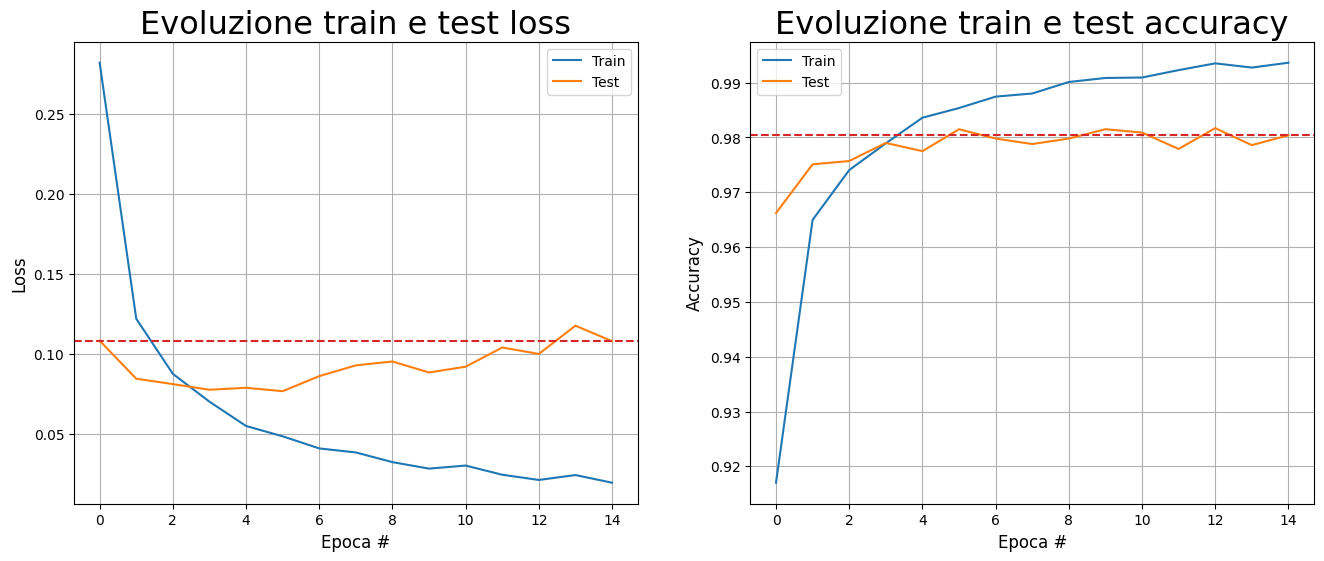

Test loss= 0.10788954794406891
Test accuracy= 0.980400025844574


In [4]:
# DNN
network, history, loss, accuracy=train_dnn(optimizer='adam', N_epochs=15)

plt.figure(figsize=(16,6))
# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='Train')
plt.plot(history.history['val_loss'],label='Test')
plt.axhline(y=loss, color='tab:red',linestyle='--')
plt.xlabel('Epoca #',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Evoluzione train e test loss',fontsize=23)
plt.grid(True)
plt.legend()
# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['acc'],label='Train')
plt.plot(history.history['val_acc'],label='Test')
plt.axhline(y=accuracy, color='tab:red',linestyle='--')
plt.xlabel('Epoca #',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('Evoluzione train e test accuracy',fontsize=23)
plt.grid(True)
plt.legend()
plt.show()

print('Test loss=', loss)
print('Test accuracy=', accuracy)

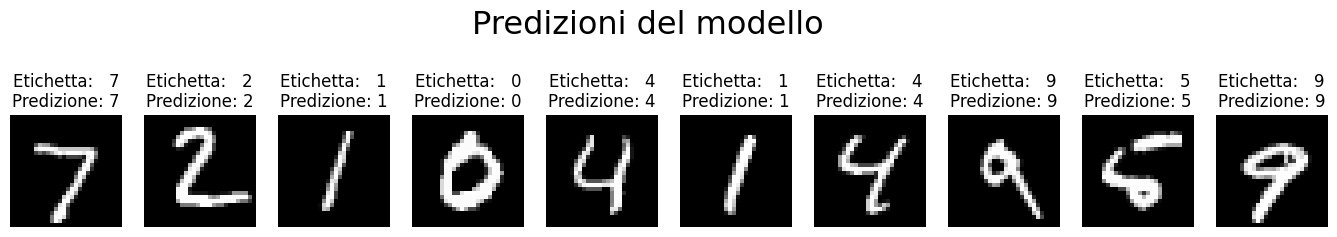

In [5]:
predictions=network.predict(x_test,verbose=0)
x=x_test.reshape(x_test.shape[0],img_righe,img_colonne,1)

plt.figure(figsize=(17,17)) 
plt.suptitle('Predizioni del modello',fontsize=23,y=0.8)
for i in range(10):    
    ax=plt.subplot(2,10,i+1)    
    plt.imshow(x[i,:,:,0],cmap='gray')    
    plt.title("Etichetta:   {}\nPredizione: {}".format(np.argmax(y_test[i]),np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

I risultati mostrano che il modello è in grado di riconoscere correttamente le cifre del dataset MNIST con un’accuracy pari al $98\%$ circa.
Dai grafici si osserva tuttavia che la loss calcolata sul test set tende a stabilizzarsi su valori più elevati rispetto a quella di training, che continua invece a ridursi progressivamente.

Questo andamento indica che il modello si adatta sempre meglio ai dati di addestramento, mentre le prestazioni sui dati non visti non migliorano oltre una certa soglia, suggerendo l’inizio di un lieve fenomeno di overfitting e quindi una riduzione della capacità di generalizzazione.

## <span id="Esercizio12.2" style="color:blue">Esercizio 12.2 - Addestramento di una rete neurale convoluzionale (CNN) [^](#toc)

### Descrizione

Si procede quindi alla costruzione di una rete neurale convoluzionale (_CNN_), più adatta all’analisi di immagini rispetto a una rete interamente densa. La CNN sfrutta infatti la struttura bidimensionale dei dati, preservando l’informazione spaziale tra i pixel.

A differenza della DNN precedente, l’architettura convoluzionale utilizza layer di tipo convolutional che applicano filtri locali, consentendo l’estrazione di proprietà rilevanti e la modellizzazione delle correlazioni spaziali. Per tale motivo è necessario ridefinire l’input, mantenendo la forma originale delle immagini anziché appiattirle in vettori monodimensionali.

### Calcolo e risultati

Come nel caso precedente:
- è stato scelto $N_{\mathrm{epochs}}=15$;
- è stato utilizzato l'ottimizzatore `adam`.

In [6]:
# 1. Load and process data
(x_t,y_t),(x_test,y_test)=mnist.load_data()    # Train and test data

# Reshape data
x_t=x_t.reshape(x_t.shape[0],img_righe,img_colonne,1)
x_test=x_test.reshape(x_test.shape[0],img_righe,img_colonne,1)
input_shape=(img_righe,img_colonne,1)
x_t=x_t.astype('float32')/255
x_test=x_test.astype('float32')/255
y_train=keras.utils.to_categorical(y_t, num_classi)
y_test=keras.utils.to_categorical(y_test, num_classi)

# 2. Define CNN architecture
def build_cnn():
    network=Sequential()
    network.add(Input(shape=input_shape))
    network.add(Conv2D(32,(3,3),activation='relu'))
    network.add(MaxPooling2D((2,2)))
    network.add(Dropout(0.25))
    network.add(Conv2D(64,(3,3),activation='relu'))
    network.add(MaxPooling2D((2,2)))
    network.add(Dropout(0.25))
    network.add(Flatten())
    network.add(Dense(128,activation='relu'))
    network.add(Dropout(0.5))
    network.add(Dense(num_classi,activation='softmax'))      # Output layer
    return network

# 3. Compile CNN model 
def compile_cnn(optimizer):
    network=build_cnn()
    network.compile(loss=keras.losses.categorical_crossentropy,optimizer=optimizer,metrics=['acc'])
    return network

# 4. Train CNN model
def train_cnn(optimizer, N_epochs):
    network=compile_cnn(optimizer)
    history=network.fit(x_t,y_train,batch_size=32,epochs=N_epochs,shuffle=True,verbose=0,validation_data=(x_test, y_test))
    loss, accuracy=network.evaluate(x_test,y_test,batch_size=32,verbose=0)
    return network,history,loss,accuracy

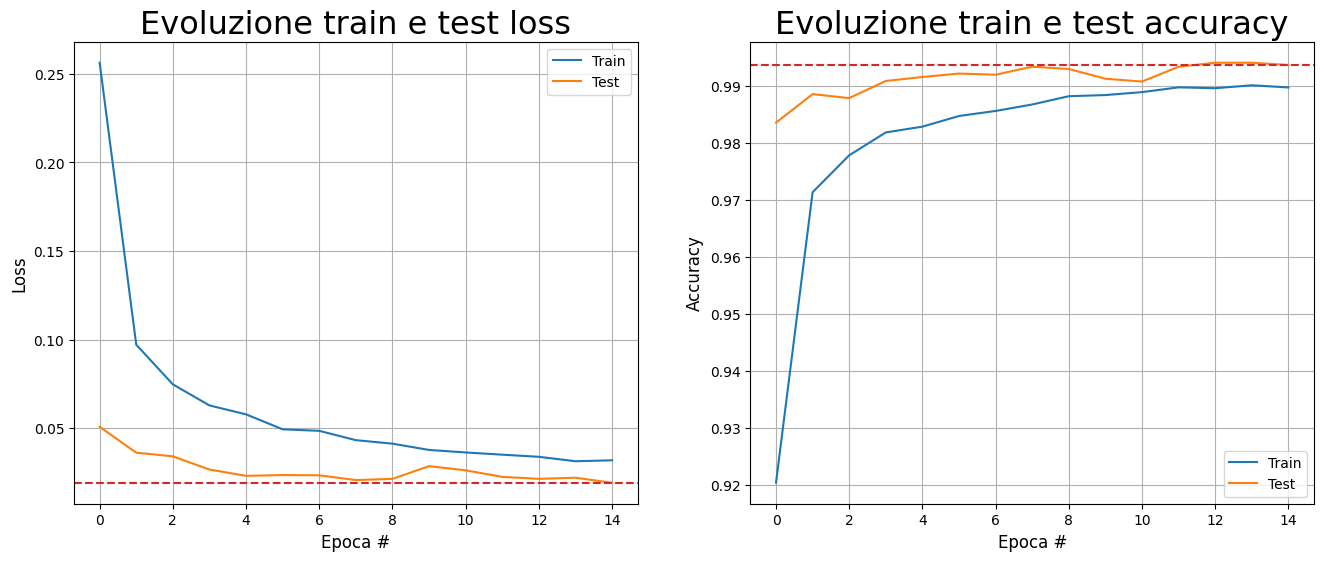

In [7]:
# CNN
network,history,loss,accuracy=train_cnn(optimizer='adam',N_epochs=15)

plt.figure(figsize=(16,6))
# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='Train')
plt.plot(history.history['val_loss'],label='Test')
plt.axhline(y=loss, color='tab:red',linestyle='--')
plt.xlabel('Epoca #',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Evoluzione train e test loss',fontsize=23)
plt.grid(True)
plt.legend()
# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['acc'],label='Train')
plt.plot(history.history['val_acc'],label='Test')
plt.axhline(y=accuracy, color='tab:red',linestyle='--')
plt.xlabel('Epoca #',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('Evoluzione train e test accuracy',fontsize=23)
plt.grid(True)
plt.legend()
plt.show()

Dall’andamento delle curve si osserva che
- la loss sul validation set converge rapidamente verso valori $\approx0.02$;
- l’accuratezza raggiunge il $99.4\%$.

In [8]:
print(f"Test loss={loss}")
print(f"Test accuracy={accuracy}")

Test loss=0.019310740754008293
Test accuracy=0.9936000108718872


Rispetto alla DNN precedente, la CNN mostra un miglioramento significativo delle prestazioni, confermando che l’utilizzo di layer convoluzionali permette di sfruttare in modo più efficace la struttura spaziale delle immagini.

Le curve di train e test risultano inoltre molto vicine tra loro, indicando una buona capacità di generalizzazione e l’assenza di fenomeni evidenti di overfitting.

## <span id="Esercizio12.3" style="color:blue">Esercizio 12.3 - Riconoscimento di 10 cifre scritte a mano [^](#toc)

### Descrizione 

In questo ultimo esercizio viene verificato il funzionamento della CNN addestrata su MNIST utilizzando $10$ immagini realizzate manualmente.

### Calcolo e risultati

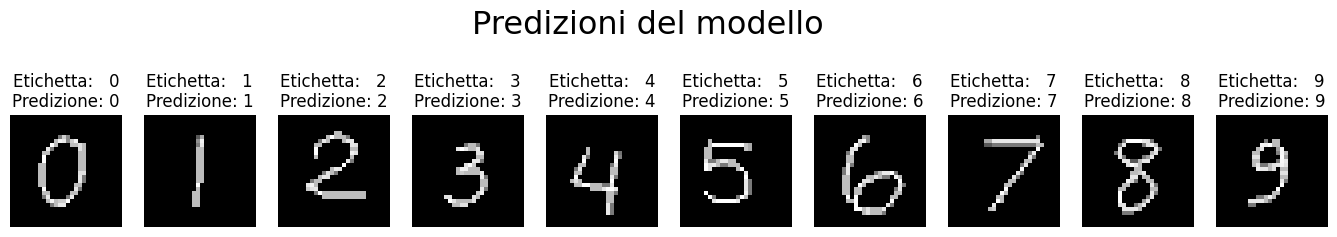

In [9]:
image_paths=["digits/0.png","digits/1.png","digits/2.png","digits/3.png","digits/4.png","digits/5.png","digits/6.png","digits/7.png","digits/8.png","digits/9.png", ]
data=[]

for path in image_paths:
    image_input=Image.open(path).convert('L').resize((28,28))
    xdim,ydim=image_input.size
    img=np.asarray(image_input,dtype=np.float32)/255
    data.append(img)
predictions=[0]*10
for i in range(10):
    arr4d=data[i].reshape(1,28,28,1)
    predictions[i]=network.predict(arr4d,verbose=0)
    
plt.figure(figsize=(17,17))     
plt.suptitle('Predizioni del modello',fontsize=23,y=0.8)
for i in range(10):    
    ax=plt.subplot(2,10,i+1)    
    plt.imshow(data[i],cmap='gray')    
    plt.title("Etichetta:   "+str(i)+"\nPredizione: {}".format(np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

Il modello ha classificato correttamente tutte le $10$ cifre fornite, mostrando una buona capacità di generalizzazione anche su immagini esterne al dataset originale